In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import time

from math import sqrt
from numpy import array
from pandas import DataFrame, read_csv, concat
from keras import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df = pd.read_csv('datapoints.csv')
df['date'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index(pd.DatetimeIndex(df['date']))
df.drop(['attribute_name', 'date'], axis=1, inplace=True)
df["datetime"] = df.index 

mask = df.name.str.contains("BLOK61")
df_blok = df[mask]
df_videolab = df[~mask]
df_videolab_filtered = df_videolab["value"].to_numpy()

df_videolab


,timestamp,name,value,datetime
date,,,,
2021-04-18 05:03:14.376,2021-04-18 05:03:14.376,Philitelaan Videolab,3.0,2021-04-18 05:03:14.376
2021-04-18 05:04:16.815,2021-04-18 05:04:16.815,Philitelaan Videolab,3.0,2021-04-18 05:04:16.815
2021-04-23 04:20:38.034,2021-04-23 04:20:38.034,Philitelaan Videolab,5.0,2021-04-23 04:20:38.034
2021-04-23 04:21:42.956,2021-04-23 04:21:42.956,Philitelaan Videolab,5.0,2021-04-23 04:21:42.956
2021-04-18 05:05:27.871,2021-04-18 05:05:27.871,Philitelaan Videolab,3.0,2021-04-18 05:05:27.871
...,...,...,...,...
2021-05-02 04:57:04.904,2021-05-02 04:57:04.904,Philitelaan Videolab,4.0,2021-05-02 04:57:04.904
2021-05-02 04:58:08.602,2021-05-02 04:58:08.602,Philitelaan Videolab,4.0,2021-05-02 04:58:08.602
2021-05-02 04:59:08.637,2021-05-02 04:59:08.637,Philitelaan Videolab,4.0,2021-05-02 04:59:08.637


In [3]:
df_videolab = df_videolab.resample(rule='15T', closed='left', label='left').mean().apply(np.ceil)


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

df_videolab = series_to_supervised(df_videolab, n_in=5)

df_videolab


,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
date,,,,,,
2021-04-05 03:15:00,3.0,3.0,3.0,3.0,3.0,3.0
2021-04-05 03:30:00,3.0,3.0,3.0,3.0,3.0,3.0
2021-04-05 03:45:00,3.0,3.0,3.0,3.0,3.0,3.0
2021-04-05 04:00:00,3.0,3.0,3.0,3.0,3.0,3.0
2021-04-05 04:15:00,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...
2021-05-06 15:30:00,11.0,11.0,11.0,11.0,10.0,8.0
2021-05-06 15:45:00,11.0,11.0,11.0,10.0,8.0,7.0
2021-05-06 16:00:00,11.0,11.0,10.0,8.0,7.0,7.0


In [5]:
n_train_percentage = 0.7
split_index = math.floor(len(df_videolab)*n_train_percentage)
train, test = df_videolab.iloc[:split_index], df_videolab.iloc[split_index:]
train_y, train_X= train.pop("var1(t)"), train.to_numpy()
test_y, test_X = test.pop("var1(t)"), test.to_numpy()

print(len(train))
print(len(test))

train_X = train_X.reshape(-1, 1, train_X.shape[1])
test_X = test_X.reshape(-1, 1, test_X.shape[1])



print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#samples, timesteps, features

2039
874
(2039, 1, 5) (2039,) (874, 1, 5) (874,)


Epoch 1/50
29/29 - 25s - loss: 6.4409 - val_loss: 6.7759
Epoch 2/50
29/29 - 0s - loss: 4.8787 - val_loss: 4.9967
Epoch 3/50
29/29 - 0s - loss: 3.1692 - val_loss: 3.1353
Epoch 4/50
29/29 - 0s - loss: 2.1358 - val_loss: 2.1967
Epoch 5/50
29/29 - 0s - loss: 1.8032 - val_loss: 1.9852
Epoch 6/50
29/29 - 0s - loss: 1.5960 - val_loss: 1.7780
Epoch 7/50
29/29 - 0s - loss: 1.3912 - val_loss: 1.5819
Epoch 8/50
29/29 - 0s - loss: 1.2403 - val_loss: 1.4474
Epoch 9/50
29/29 - 0s - loss: 1.1441 - val_loss: 1.2980
Epoch 10/50
29/29 - 0s - loss: 1.0584 - val_loss: 1.1784
Epoch 11/50
29/29 - 0s - loss: 0.9967 - val_loss: 1.0871
Epoch 12/50
29/29 - 0s - loss: 0.9460 - val_loss: 1.0204
Epoch 13/50
29/29 - 0s - loss: 0.9041 - val_loss: 0.9764
Epoch 14/50
29/29 - 0s - loss: 0.8734 - val_loss: 0.9268
Epoch 15/50
29/29 - 0s - loss: 0.8446 - val_loss: 0.8921
Epoch 16/50
29/29 - 0s - loss: 0.8214 - val_loss: 0.8634
Epoch 17/50
29/29 - 0s - loss: 0.7991 - val_loss: 0.8349
Epoch 18/50
29/29 - 0s - loss: 0.7810 -

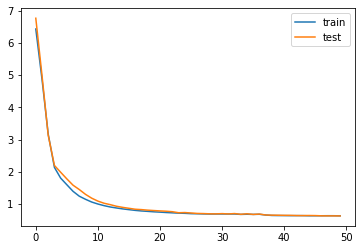

In [6]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



In [11]:
# make a prediction
yhat = model.predict(test_X[2])
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: in user code:

    /home/niek/.local/lib/python3.9/site-packages/keras/engine/training.py:1544 predict_function  *
        return step_function(self, iterator)
    /home/niek/.local/lib/python3.9/site-packages/keras/engine/training.py:1527 run_step  *
        outputs = model.predict_step(data)
    /home/niek/.local/lib/python3.9/site-packages/keras/engine/training.py:1500 predict_step  *
        return self(x, training=False)
    /home/niek/.local/lib/python3.9/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/niek/.local/lib/python3.9/site-packages/keras/engine/input_spec.py:212 assert_input_compatibility  *
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 5)


In [10]:
test_X[0]

array([[9., 9., 9., 8., 9.]])